<a href="https://colab.research.google.com/github/SaiidAmiri/Deep-Learning-Projects-with-PyTorch/blob/main/Copy_of_Facial_Expression_Recognition_with_PyTorch_CLEANED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libraries, packages and dataset

In [ ]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Cloning into 'Facial-Expression-Dataset'...
remote: Enumerating objects: 34052, done.
remote: Total 34052 (delta 0), reused 0 (delta 0), pack-reused 34052 (from 1)
Receiving objects: 100% (34052/34052), 52.31 MiB | 18.72 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (35887/35887), done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-p5263iwr
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-p5263iwr
  Resolved https://github.com/albumentations-team/albumentations to commit cbb00e88030ba274e0bcca0953fb756cff21a510
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.23
    Uninstalling albucore-0.0.23:
      Successfully uninstalled albucore-0.0.23
ERROR: pip's dependency resolver does not 

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Configurations

In [ ]:
TRAIN_IMG_FOLDER_PATH = "/content/Facial-Expression-Dataset/train"
VALID_IMG_FOLDER_PATH = "/content/Facial-Expression-Dataset/validation"

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "efficientnet_b0"

# Load Dataset

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [ ]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor() # PIL format numpy arr -> torch tensor -> (h,w, c) -> (c, h, w)
])

valid_augs = T.Compose([
    T.ToTensor()
])

In [ ]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform = valid_augs)

In [ ]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [ ]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '6')

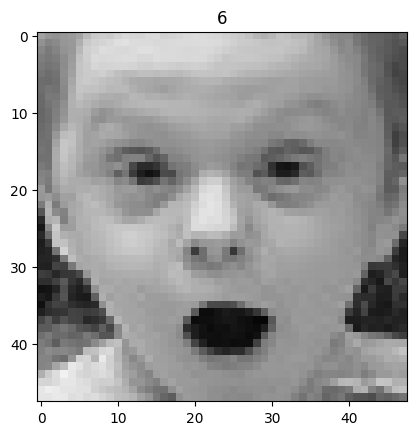

In [ ]:
image, label = validset[7000]

plt.imshow(image.permute(1, 2, 0))  # (h, w, c)
plt.title(label)

# Load Dataset into Batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size =  BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [ ]:
for images, labels in trainloader:
  break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Create Model

In [ ]:
import timm
from torch import nn

In [ ]:
class FaceModel(nn.Module):

  def __init__(self):
    super(FaceModel, self).__init__()

    self.eff_net = timm.create_model('efficientnet_b0', pretrained = True, num_classes = 7)

  def forward(self, images, labels = None):

    logits = self.eff_net(images)

    if labels != None:
      loss = nn.CrossEntropyLoss()(logits, labels)
      return logits, loss
    return logits

In [ ]:
model = FaceModel()
model.to(DEVICE);

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

# Create Train and Eval Function

In [ ]:
from tqdm import tqdm

In [ ]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
def train_fn(model, dataloader, optmizer, current_epo):

  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo + 1) + "/" + str(EPOCHS))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1)),})

  return total_loss / len(dataloader), total_acc / len(dataloader)

In [ ]:
def eval_fn(model, dataloader, current_epo):

  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "EPOCH" + "[VALID]" + str(current_epo + 1) + "/" + str(EPOCHS))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits, loss = model(images, labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1)),})

  return total_loss / len(dataloader), total_acc / len(dataloader)

# Create Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.inf

for i in range(EPOCHS):
  train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
  valid_loss, valid_acc = eval_fn(model, validloader, i)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    print("SAVED-BEST-WEIGHTS")
    best_valid_loss = valid_loss

EPOCH[VALID]1/15: 100%|██████████| 221/221 [00:06<00:00, 31.93it/s, loss=1.347497, acc=0.486969]


SAVED-BEST-WEIGHTS


EPOCH[VALID]2/15: 100%|██████████| 221/221 [00:06<00:00, 32.74it/s, loss=1.201770, acc=0.541605]


SAVED-BEST-WEIGHTS


EPOCH[VALID]3/15: 100%|██████████| 221/221 [00:06<00:00, 36.39it/s, loss=1.139421, acc=0.562489]


SAVED-BEST-WEIGHTS


EPOCH[VALID]4/15: 100%|██████████| 221/221 [00:06<00:00, 36.50it/s, loss=1.095278, acc=0.584374]


SAVED-BEST-WEIGHTS


EPOCH[VALID]5/15: 100%|██████████| 221/221 [00:06<00:00, 33.60it/s, loss=1.047091, acc=0.601690]


SAVED-BEST-WEIGHTS


EPOCH[VALID]7/15: 100%|██████████| 221/221 [00:06<00:00, 33.28it/s, loss=1.041431, acc=0.622052]


SAVED-BEST-WEIGHTS


EPOCH[VALID]10/15: 100%|██████████| 221/221 [00:06<00:00, 34.98it/s, loss=1.041222, acc=0.621595]


SAVED-BEST-WEIGHTS


EPOCH[VALID]11/15: 100%|██████████| 221/221 [00:06<00:00, 36.54it/s, loss=0.980908, acc=0.633680]


SAVED-BEST-WEIGHTS


EPOCH[VALID]13/15: 100%|██████████| 221/221 [00:06<00:00, 35.34it/s, loss=0.975350, acc=0.641240]


SAVED-BEST-WEIGHTS


EPOCH[VALID]14/15: 100%|██████████| 221/221 [00:06<00:00, 32.89it/s, loss=0.967146, acc=0.640108]


SAVED-BEST-WEIGHTS


EPOCH[VALID]15/15: 100%|██████████| 221/221 [00:06<00:00, 32.39it/s, loss=1.003691, acc=0.640609]


# Inference

In [ ]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [ ]:
# Get a random batch from a DataLoader
import random
total_batches = len(validloader)
rand_batch_idx = random.randint(0, total_batches - 1)

for i, batch in enumerate(validloader):
    if i == rand_batch_idx:
        images, labels = batch
        break

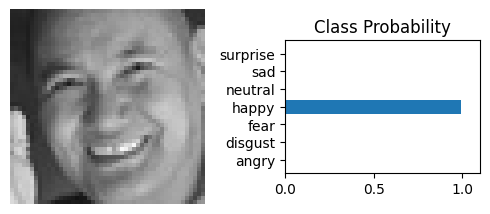

In [ ]:
# Pick one random image from the random batch
rand_idx = random.randint(0, images.size(0) - 1)

img = images[rand_idx]
label = labels[rand_idx]

# Run through model
model.eval()
with torch.no_grad():
    output = model(img.unsqueeze(0).to(DEVICE))
    ps = torch.nn.functional.softmax(output, dim=1)

view_classify(img, ps)